In [1]:
import wandb
import numpy as np
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)


In [2]:
import os
os.environ.get("LD_LIBRARY_PATH")

'/eos/home-g/gkrzmanc/miniforge3/lib:/home/gkrzmanc/env/lib:'

In [34]:
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np
import torch
print("CUDA available:", torch.cuda.is_available())  # in case needed


def get_dataset():
    path = "/afs/cern.ch/work/g/gkrzmanc/mlpf_results/clustering_gt_with_pid_and_mean_features/cluster_features"
    r = {}
    n = 0
    #nmax = 257
    for file in os.listdir(path):
        #n += 1
        #if n > nmax:
        #    break
        f = pickle.load(open(os.path.join(path, file), "rb"))
        for key in f:
            if key not in r:
                r[key] = f[key]
            else:
                r[key] = torch.concatenate((r[key], f[key]), axis=0)
    x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
    h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg"]
    h1_names = ["hit_eta_avg", "hit_phi_avg"]
    print("x shape:", r["x"].shape)
    xyz = r["node_features_avg"][:, [0,1,2]].cpu()
    eta_phi = torch.stack([calculate_eta(xyz[:, 0], xyz[:, 1], xyz[:, 2]), calculate_phi(xyz[:, 0], xyz[:, 1])], dim=1)
    return torch.concatenate([r["x"], xyz, eta_phi], dim=1), x_names + h_names + h1_names, r["true_e_corr"], r["e_true"], r["e_reco"], r["y_particles"][:, 6]


def get_split(ds):
    from sklearn.model_selection import train_test_split
    x, _, y, etrue, _, pids = ds
    xtrain, xtest, ytrain, ytest, energiestrain, energiestest, pid_train, pid_test = train_test_split(
        x, y, etrue, pids, test_size=0.2, random_state=42
    )
    return xtrain, xtest, ytrain, ytest, energiestrain, energiestest, pid_train, pid_test

def get_gb():
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor(verbose=1)
    return model

def calculate_phi(x, y):
    return np.arctan2(y, x)

def calculate_eta(x, y, z):
    theta = np.arctan2(np.sqrt(x**2 + y**2), z)
    return -np.log(np.tan(theta/2))

def get_nn():
    from sklearn.neural_network import MLPRegressor
    model = MLPRegressor(hidden_layer_sizes=(30, 30), verbose=True, max_iter=1000)
    return model


def main(ds, train_only_on_tracks=False, train_only_on_neutral=False, train_energy_regression=False, train_only_on_PIDs=[], remove_sum_e=False):
    split = list(get_split(ds))
    model = get_gb()
    if train_only_on_tracks:
        mask = (split[0][:, 3] > 0) & (split[0][:, 7] == 1)
        split[0] = split[0][mask]
        split[2] = split[2][mask]
        split[4] = split[4][mask]
    elif train_only_on_neutral:
        mask = (split[0][:, 3] == 0) & (split[0][:, 7] == 0)
        split[0] = split[0][mask]
        split[2] = split[2][mask]
        split[4] = split[4][mask]
    elif train_only_on_PIDs:
        mask = [i in train_only_on_PIDs for i in split[6]]
        mask = torch.tensor(mask)
        split[0] = split[0][mask]
        split[2] = split[2][mask]
        split[4] = split[4][mask]
    if remove_sum_e:
        split[0][:, 6] = 0.0  # remove the sum of the hits 
    if not train_energy_regression:
        result = model.fit(split[0], split[2])
        print("Fitted model:", result)
        # validation
        ysum = split[1][:, 6]
        ypred = model.predict(split[1])
        epred = ysum * (1 + ypred)
        ytrue = split[3]
        energies = split[5]
        return ytrue, epred, energies, split[1], model, split
    else:
        result = model.fit(split[0], split[4])
        print("Fitted model:", result)
        # validation
        epred = model.predict(split[1])
        ytrue = split[3]
        ysum = split[1][:, 6]
        ypred = epred / ysum - 1
        energies = split[5]
        return ytrue, epred, energies, split[1], model, split
        # log scatterplots of validation results per energy
    #else:
    #    raise NotImplementedError



CUDA available: True


In [25]:
ds = get_dataset()
print("Loaded dataset")

KeyboardInterrupt: 

In [40]:
yt, yp, en, _, model, split = main(ds=ds, train_energy_regression=False, train_only_on_PIDs=[211], remove_sum_e=False)

      Iter       Train Loss   Remaining Time 
         1           3.0837            4.09s
         2           2.5693            3.61s
         3           2.1499            3.41s
         4           1.8082            3.29s
         5           1.5317            3.17s
         6           1.3045            3.13s
         7           1.1196            3.19s
         8           0.9688            3.14s
         9           0.8454            3.07s
        10           0.7449            2.99s
        20           0.3496            2.55s
        30           0.2436            2.23s
        40           0.2093            1.97s
        50           0.1299            1.62s
        60           0.0943            1.27s
        70           0.0768            0.94s
        80           0.0607            0.62s
        90           0.0487            0.31s
       100           0.0419            0.00s
Fitted model: GradientBoostingRegressor(verbose=1)


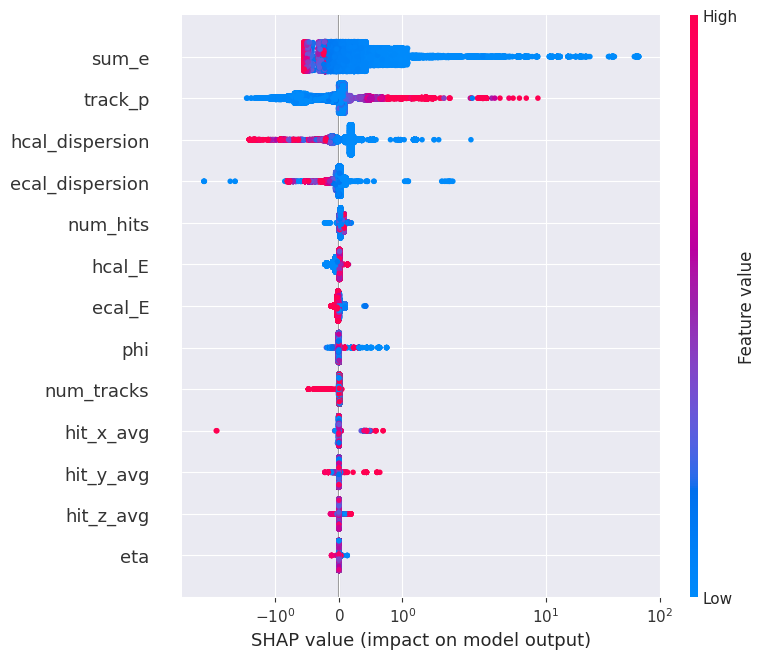

In [41]:
import shap
import numpy as np

te = shap.TreeExplainer(model)
shap_vals_r = te.shap_values(np.array(split[1]))
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg", "eta", "phi"]
shap.summary_plot(shap_vals_r, split[1], feature_names=x_names+h_names, use_log_scale=True, show=False)
#plt.savefig("/eos/user/g/gkrzmanc/2024/12_3_/shap_summary_tracks_Regression_with_XYZ.pdf")
plt.show()

In [9]:
import numpy as np
def get_std68(theHist, bin_edges, percentage=0.683, epsilon=0.01):
    # theHist, bin_edges = np.histogram(data_for_hist, bins=bins, density=True)
    wmin = 0.2
    wmax = 1.0

    weight = 0.0
    points = []
    sums = []

    # fill list of bin centers and the integral up to those point
    for i in range(len(bin_edges) - 1):
        weight += theHist[i] * (bin_edges[i + 1] - bin_edges[i])
        points.append([(bin_edges[i + 1] + bin_edges[i]) / 2, weight])
        sums.append(weight)
    low = wmin
    high = wmax
    width = 100
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
            if abs(wy - percentage) < epsilon:
                wx = points[j][0] - points[i][0]
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    width = wx

    return 0.5 * (high - low), low, high

def mean_without_outliers(data):
    remove_count = int(len(data) * 0.01)
    # Sort the array
    sorted_arr = np.sort(data)
    # Remove the lowest and highest 1% of the elements
    trimmed_arr = sorted_arr[remove_count:-remove_count]
    # Calculate the mean of the trimmed array
    mean = np.mean(trimmed_arr)
    return mean

def obtain_MPV_and_68_raw(data_for_hist, bins_per_binned_E=np.arange(-1, 5, 0.01), epsilon=0.01):
    hist, bin_edges = np.histogram(data_for_hist, bins=bins_per_binned_E, density=True)
    ind_max_hist = np.argmax(hist)
    #MPV = (bin_edges[ind_max_hist] + bin_edges[ind_max_hist + 1]) / 2
    std68, low, high = get_std68(hist, bin_edges, epsilon=epsilon)
    MPV = mean_without_outliers(data_for_hist)
    return MPV, std68, low, high

def obtain_MPV_and_68(data_for_hist, *args, **kwargs):
    # trim the data for hist by removing the top and bottom 1%
    data_for_hist = data_for_hist[(data_for_hist > np.percentile(data_for_hist, 1)) & (data_for_hist < np.percentile(data_for_hist, 99))]
    # bins_per_binned_E = np.linspace(data_for_hist.min(), data_for_hist.max(), 1000)
    bins_per_binned_E = np.arange(0, 2, 1e-3)
    return obtain_MPV_and_68_raw(data_for_hist, bins_per_binned_E)
    

In [44]:
def get_charged_response_resol_plot_for_PID(pid):
    e_thresholds = [0, 6, 12, 18, 24, 30, 36, 42, 48]  # True E thresholds!
    mpvs_model, s68s_model = [], []
    mpvs_pandora, s68s_pandora = [], []
    mpvs_sum_hits, s68s_sum_hits = [], []
    e_true = (1+yt) * split[1][:, 6].numpy()
    e_pred = yp
    frac_pred = e_pred / e_true
    frac_e_sum = split[1][:, 6].clone().detach().cpu().numpy() / e_true
    e_track = split[1][:, 3].clone().detach().cpu().numpy()
    frac_track = e_track / e_true
    track_filter = ((split[1][:, 3] > 0) & (split[1][:, 7] == 1))
    track_filter = track_filter & (split[-1] == pid).cpu()
    binsize = 0.01
    bins_x = []
    for i, e_threshold in enumerate(e_thresholds):
        if i == 0:
            continue
        bins_x.append(0.5 * (e_thresholds[i] + e_thresholds[i-1]))
        filt_energy = (e_true < e_thresholds[i]) & (e_true >= e_thresholds[i-1])
        mpv, s68, lo, hi = obtain_MPV_and_68(frac_pred[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
        mpvs_model.append(mpv)
        s68s_model.append(s68)
        #mpvs_model_normalized.append(mpv)
        #mpv, s68, _, _ = obtain_MPV_and_68(e_track[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
        #mpvs_pandora, s68s_pandora = mpvs_pandora + [mpv], s68s_pandora + [s68]
        mpv, s68, lo, hi = obtain_MPV_and_68(frac_track[filt_energy & track_filter].clip(max=5), bins_per_binned_E=np.arange(0, 5, binsize))
        mpvs_pandora.append(mpv)
        s68s_pandora.append(s68)
        mpv, s68, _, _= obtain_MPV_and_68(frac_e_sum[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
        mpvs_sum_hits.append(mpv)
        s68s_sum_hits.append(s68)
        
    fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots. 
    ax[0].plot(bins_x, np.array(s68s_model) / np.array(mpvs_model), ".--", label="GradBoost")
    ax[0].plot(bins_x, np.array(s68s_pandora) / np.array(mpvs_pandora), ".--", label="track p")
    ax[0].plot(bins_x, np.array(s68s_sum_hits) / np.array(mpvs_sum_hits), ".--", label="sum hits")
    ax[0].legend()
    ax[1].set_xlabel("Energy [GeV]")
    ax[0].set_ylabel("σ / E")
    #ax[0].set_ylim([0, 0.4])
    ax[1].plot(bins_x, mpvs_model, ".--", label="GradBoost")
    ax[1].plot(bins_x, mpvs_pandora, ".--", label="track p")
    ax[1].plot(bins_x, mpvs_sum_hits, ".--", label="sum hits")
    ax[1].set_ylim([0.95, 1.05])
    ax[1].set_ylabel("response")
    ax[0].set_title("PID: " + str(pid))
    upper_plot = {"ML": np.array(s68s_model) / np.array(mpvs_model),
                  "p": np.array(s68s_pandora) / np.array(mpvs_pandora),
                  "sum": np.array(s68s_sum_hits) / np.array(mpvs_sum_hits)}
    lower_plot = {"ML": mpvs_model, "p": mpvs_pandora, "sumhits": mpvs_sum_hits}
    return fig, upper_plot, lower_plot, bins_x


/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


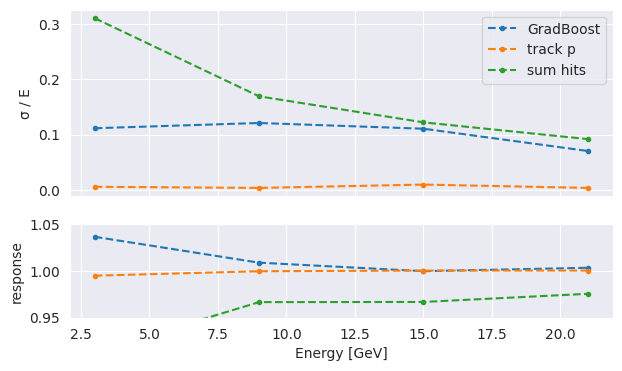

In [42]:
get_charged_response_resol_plot_for_PID(211).show()


In [45]:
def get_plots(PIDs, energy_regression=False, remove_sum_e=False):
    yt, yp, en, _, model, split = main(ds=ds, train_energy_regression=energy_regression, train_only_on_PIDs=PIDs, remove_sum_e=remove_sum_e)
    import shap
    import numpy as np
    te = shap.TreeExplainer(model)
    shap_vals_r = te.shap_values(np.array(split[1]))
    x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
    h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg", "eta", "phi"]
    shap.summary_plot(shap_vals_r, split[1], feature_names=x_names + h_names, use_log_scale=True, show=False)
    plt.show()
    results = {}
    for pid in PIDs:
        fig, upper, lower, x = get_charged_response_resol_plot_for_PID(pid)
        fig.show()
        results[pid] = [upper, lower, x]


      Iter       Train Loss   Remaining Time 
         1           3.0837            3.37s
         2           2.5693            3.26s
         3           2.1499            3.19s
         4           1.8082            3.09s
         5           1.5317            3.00s
         6           1.3045            2.93s
         7           1.1196            2.88s
         8           0.9688            2.82s
         9           0.8454            2.78s
        10           0.7449            2.73s
        20           0.3496            2.35s
        30           0.2436            2.03s
        40           0.2093            1.73s
        50           0.1299            1.43s
        60           0.0943            1.14s
        70           0.0768            0.85s
        80           0.0607            0.57s
        90           0.0487            0.30s
       100           0.0419            0.00s
Fitted model: GradientBoostingRegressor(verbose=1)


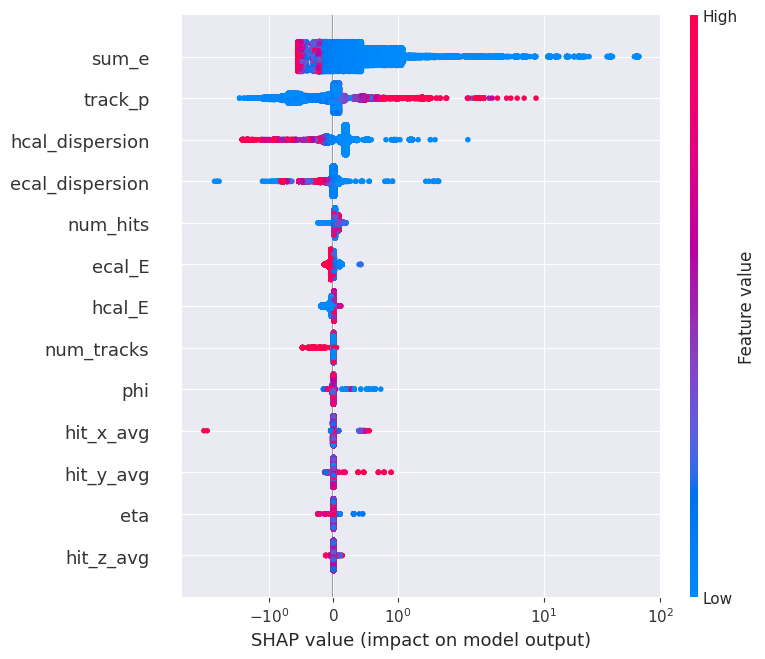

/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


      Iter       Train Loss   Remaining Time 
         1         123.7052            3.04s
         2         101.1158            2.86s
         3          82.7736            2.80s
         4          67.8300            2.75s
         5          55.5738            2.70s
         6          45.5914            2.66s
         7          37.5449            2.62s
         8          30.9069            2.58s
         9          25.5138            2.55s
        10          21.1028            2.52s
        20           3.9001            2.21s
        30           1.3292            1.92s
        40           0.8325            1.65s
        50           0.6430            1.37s
        60           0.5502            1.10s
        70           0.4992            0.82s
        80           0.4596            0.55s
        90           0.4275            0.27s
       100           0.4027            0.00s
Fitted model: GradientBoostingRegressor(verbose=1)


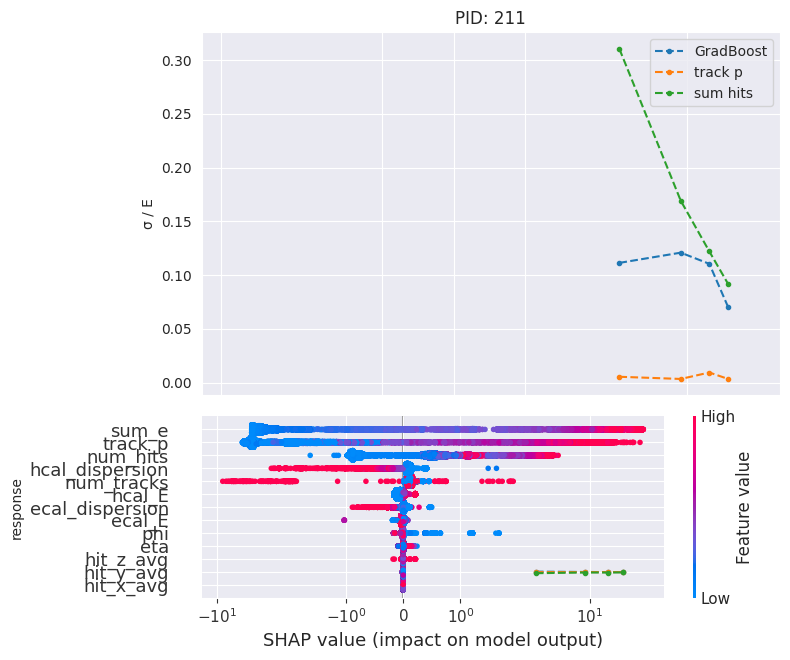

/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/gkrzmanc/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


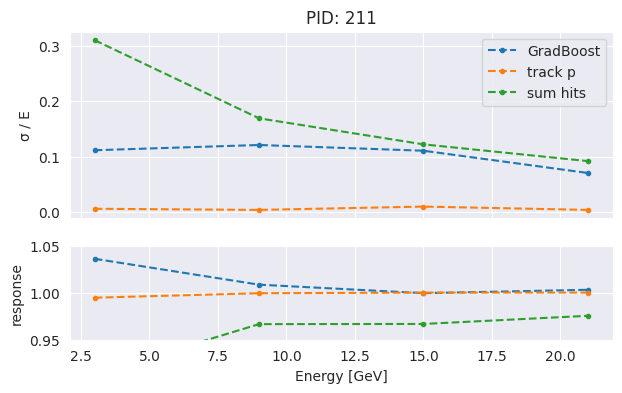

In [47]:
res_cf_regress = get_plots([211])
res_energy_regress = get_plots([211], energy_regression=True)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
bins_x = res_cf_regress[2]
upper_curve_cf = res_cf_regress[0]["ML"]
upper_curve_energy = res_energy_regress[0]["ML"]
upper_curve_pandora  = res_energy_regress[0]["p"]
upper_curve_sum_hits = res_energy_regress[0]["sumhits"]
response_cf = res_cf_regress[1]["ML"]
response_energy
ax[0].plot(bins_x, upper_curve_cf, label="ML-ECF")
ax[0].plot(bins_x, upper_curve_energy, label="ML-ER")
ax[0].plot(bins_x, upper_curve_pandora, label="track p")
ax[0].plot(bins_x, upper_curve_sum_hits, label="sum hits")
ax[0].legend()
ax[1].set_xlabel("Energy [GeV]")
ax[0].set_ylabel("σ / E")
ax[1].plot(bins_x,)
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylabel("response")
ax[0].set_title("PID: " + str(pid))

In [ ]:
neutrals = {
    "gamma": 22,
    "Klong": 130,
    "n": 2112
}
charged = {
    "pi+": 211,
    "pi-": -211,
    "p": 2212,
    "pbar": -2212,
    "e": 11
}


In [ ]:
for key in neutrals:
    fig = get_neutral_response_resolution_plot_for_PID(neutrals[key])
    fig.suptitle(key)
    fig.savefig(f"/eos/user/g/gkrzmanc/2024/19_3_/response_and_resolution_plots_smooth_mean_{key}.pdf")
    fig.show()

In [ ]:
for key in charged:
    fig = get_charged_response_resol_plot_for_PID(charged[key])
    fig.suptitle(key)
    fig.savefig(f"/eos/user/g/gkrzmanc/2024/19_3_/response_and_resolution_tracks_smooth_mean_{key}.pdf")
    fig.show()
